### downloading files data.py and models.py

the following cell contain only commands to install the kaggle command which we will use to download the tiny-imagenet dataset from kaggle 

make sure you have the kaggle.json file before running it 

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,ConcatDataset
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from models import LeNet,LeNet_BatchNorm
from data import read_data,prepare_data_loader,tiny_image_net,EMD
from gan import gan
from encoder_decoder import *
from train import *
from test import *
import random

In [ ]:
random.seed(5318008)
torch.manual_seed(5318008)

### download data set and prepare loaders

in this cell we download the datasets.
imagenet is only used to train the generative model in case of using a pretrained one, you can comment everything related to imagnet

prepare_data_loader

 validation_fraction| centralized        | centalized_testing | output
--------------------|--------------------|--------------------|--------------
         0          |      True          |      ____          | [1 train loader]
         0          |      False         |      ____          | [nb_clients train loaders]
        >0          |      True          |      ____          | [1 train loader + 1 val loader]
        >0          |      False         |      True          | [nb_clients train loaders + 1 val loader]
        >0          |      False         |      False         | [nb_clients train loaders + nb_clients val loaders]


examples

In [ ]:
class extend:
  def __call__(self,sample):
    x=sample.view((1,3,32,32))
    return x


class map_0_1: # this transformation is used for mapping yhe 0-255 value pixels 0-1
  def __init__(self,map):
    self.map=map
  def __call__(self,sample):
    x=sample/float(self.map)
    return x

if not os.path.isfile('/content/cifar-10-python.tar.gz'):
  !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !tar -xf /content/cifar-10-python.tar.gz
'''
if not os.path.isfile('/content/tiny-imagenet.zip'):
  !kaggle datasets download -d akash2sharma/tiny-imagenet
  !unzip /content/tiny-imagenet.zip
  '''

#1
train_transform = transforms.Compose([ transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

#2
train_transform_map= transforms.Compose([map_0_1(255),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trans_imagenet=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),extend()])




#data_imagenet=tiny_image_net('tiny-imagenet-200',trans_imagenet,0.5)
 
data=read_data('/content/cifar-10-batches-py') #read_data retrun a list containing couples (label,sample)


#prepare_data_loader return a set of loaders training loaders first anf the validation loader as the last element

loaders=prepare_data_loader(data,train_transform_map,alpha=100,validation_fraction=0.2) # the validation set if specified will be the last element in the loader
#loader_imagenet=prepare_data_loader(data_imagenet,train_transform)


### function to visulaize client data ditribution

In [34]:
def visualize_distribution(x_loader):
  l={i:0 for i in range(10)}
  for _,z in x_loader.dataset:
    l[z.item()]+=1
  plt.hist(list(l.keys()),weights=list(l.values()),bins=[0.75+i*0.5 for i in range(18)],align='mid')
  plt.xticks(np.arange(0, 10, step=1))
  

In [ ]:
x=prepare_data_loader(data,train_transform_map,centralized=False,centralized_testing=False,alpha=1,validation_fraction=0.2)

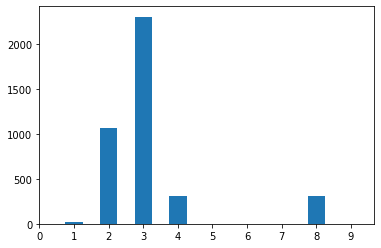

In [61]:
visualize_distribution(x[1])

### GAN

gan is a function from the gan.py file it takes as arguments nb of epochs, tarining loader and a set of parameters (Nz,Ndf,Ngf) that control the size of the gan model use the default values for the small gan (similar to letnet size)
or (Nz=100,Ndf=128,Ngf=128) for the extra wide gan.

it returns a gan model

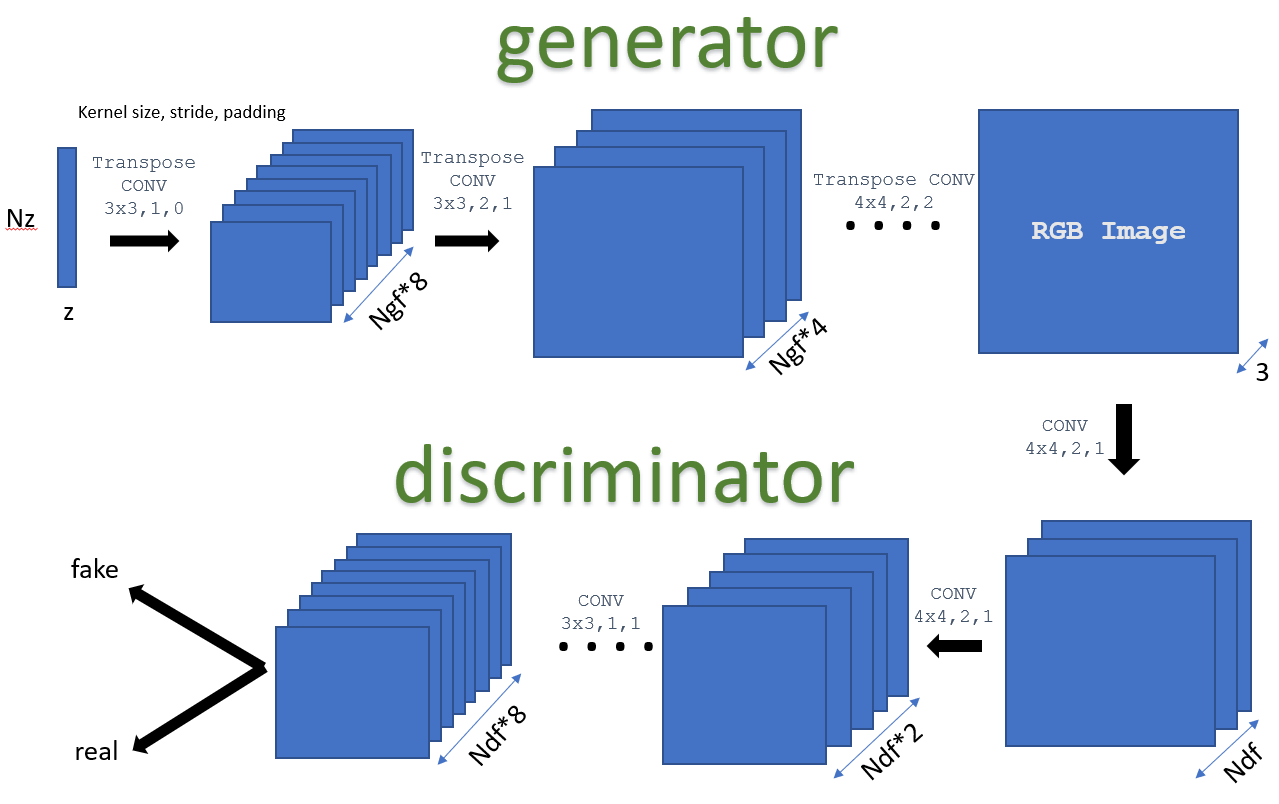

In [ ]:
#generator=gan(400,loader_imagenet[0]) #when training 

# for using a pretrained gan we first need to initialize/ initiate the model then load the weights
generator=gan(0,None)
generator.load_state_dict(torch.load('gan_model'))

<All keys matched successfully>

### AutoEncoder

In [ ]:
decoder,mean_tiny_img_net,cov_tiny_img_net=train_encoder_decoder(120,loader_imagenet[0],Device='cuda') #this method work similar to the gan method abovve but it also return the mean and cov matrix of the embeded space (not a variational autoencoder)

### Display

the cell below display an image created by the generative models alongside an image from imagenet you can just remove imagenet part if you are not intrested in it

In [ ]:
import torchvision.utils as vutils
#z=torch.from_numpy(np.random.multivariate_normal(mean_tiny_img_net,cov_tiny_img_net).astype(np.float32))
#decoder.train(False)
#z=torch.normal(torch.zeros((1,128,1,1)),1)

#z=z.view((1,128,1,1))
#d3=decoder(z.to('cuda'))


# for wide gan
z=torch.randn(1, 100, 1, 1) 
# or z=torch.randn(1, 25, 1, 1)  for the small gan
z=z.to('cuda')
d3=generator(z)
d3=d3/(d3.max())
print(d3)

d3-=d3.min()
d3=d3/d3.max()
plt.figure(figsize=(10,10))

d5=loader_imagenet[0].dataset[27][0].to('cpu').view((1,3,32,32))
d5=d5/(d5.max()-d5.min())
plt.imshow(np.transpose(vutils.make_grid(torch.cat((d3[0].to('cpu').view((1,3,32,32)),
                              d5)),
                                padding=2 ),(1,2,0)))


#learning rate tuning

learning rate hyperparameter tuning for 20 epochs in centralized setting

In [ ]:
learning_rates=[0.2,0.15,0.1,0.08,0.06,0.05,0.04,0.02,0.01,0.005]
weight_decay=10**-4
loss=nn.CrossEntropyLoss()
results=[]
acc_val=[]
z=0
for lr in learning_rates:
  net=LeNet(3,10)
  net.to('cuda')

  optimizer=torch.optim.SGD(net.parameters(),lr,weight_decay)
  for i in range(30):
    lo,acc=train(net,loaders[0],optimizer,loss,'cuda')
    if(i==29):
      z=z+1
      results.append(f'lr= {lr}: loss= {lo}, acc= {acc}')
      print(f'step {z} out of {len(learning_rates)}')
  acc_val.append(test(net,loaders[1],'cuda'))

torch.save({'acc_val':acc_val,'training':results},'parameter-tuning')

#weight and loss def

In [ ]:
weight_decay=10**-4
loss=nn.CrossEntropyLoss()

#centralized

training loop for 120 epochs centralized

torch.Size([40000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


step 0 out of 120
step 1 out of 120
step 2 out of 120
step 3 out of 120
step 4 out of 120
step 5 out of 120
step 6 out of 120
step 7 out of 120
step 8 out of 120
step 9 out of 120
step 10 out of 120
step 11 out of 120
step 12 out of 120
step 13 out of 120
step 14 out of 120
step 15 out of 120
step 16 out of 120
step 17 out of 120
step 18 out of 120
step 19 out of 120
step 20 out of 120
step 21 out of 120
step 22 out of 120
step 23 out of 120
step 24 out of 120
step 25 out of 120
step 26 out of 120
step 27 out of 120
step 28 out of 120
step 29 out of 120
step 30 out of 120
step 31 out of 120
step 32 out of 120
step 33 out of 120
step 34 out of 120
step 35 out of 120
step 36 out of 120
step 37 out of 120
step 38 out of 120
step 39 out of 120
step 40 out of 120
step 41 out of 120
step 42 out of 120
step 43 out of 120
step 44 out of 120
step 45 out of 120
step 46 out of 120
step 47 out of 120
step 48 out of 120
step 49 out of 120
step 50 out of 120
step 51 out of 120
step 52 out of 120
ste

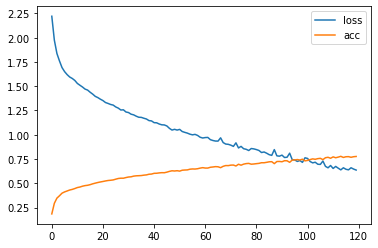

In [ ]:
net=LeNet(3,10)
net.to('cuda')
lo,acc=[],[]
loaders=prepare_data_loader(data,train_transform,validation_fraction=0.2)
optimizer=torch.optim.SGD(net.parameters(),0.1,weight_decay)
for i in range(120):
  x,y=train(net,loaders[0],optimizer,loss,'cuda')
  print(f'step {i} out of 120')
  lo.append(x)
  acc.append(y)
accuracy=test(net,loaders[1],'cuda')
plt.plot(range(120),lo,label='loss')
plt.plot(range(120),acc,label='acc')
plt.legend()

In [ ]:
accuracy

0.4817

#federated_learning


*   **data**: data list(label,sample)
*   **model**: 'LeNet' for standad lenet model , else : batchnorm lenet architecture
*   **nbclients** : the total number of clients for whom the data is distributed
*   **alpha**: controls heteroginity level 0.01-> max heteroginity , 1000+ for homogenous data
*   **lr**: learning rate
*   **epoch**: nb of local epochs performed at the client side between rounds
*   **clients_per_round**: the fraction of clients choosed at each round to perform training
*   **val_fraction**: validation fraction control the amount of data used for the validation phase
*   **transform**: the transfromation functions performed on the data whole creating the loaders
*    **nb_rounds**: the number of rounds for which the model is trained
*    **mu**: the hyperparameter used to control the contibution of fedprox regularization term ( if fedprox is not used you can ignore it
*   **wr**: the hyperparamter used to control the contribution of misclassifying a random/noise/unkown sample generated by the generative model used only with FedExt (the random/unkown loss weight)
*   **fr**: a hyperparameter used to control the fraction of random samples generated by (generative model) also used with FedExt ( the fraction is propotionel to the data present at the client side for exaple if each client has 2000 training samples and fr=0.4 => 800 random samples will be generated for that client)
*   **cycle**: a hyperparameter controlling if we want to reuse the generated random sample for each client at each round or we want to generate new samples each round  (with FedExt). it is better to set it to false since it is computationaly expensinve to cycle the random samples each round and there is no much gain in term of accuracy
*   **mode**: 4 possible modes => fedExt / fedAvg / fedProx / fedIR
*  **generation_model**: a dictinary containing the generative model with some extra information : type {gan,autoencoder} ,model, Nz for gan {100 for the wide gan and 25 for the samll one} , in case of using the autoencoder add mean and covariance



```
example : model_generation={
    'type':'gan',
    'model':generator,
    'Nz':25,
    #'mean':np.zeros(128),
    #'cov':cov_tiny_img_net,
}
```



In [ ]:


def federated_training(data,model='LeNet',nbclients=20,alpha=10000,lr=0.1,epoch=1,clients_per_round=0.2,val_fraction=0.2,
                       transform=train_transform,nb_rounds=120,mu=0.1,wr=1,fr=0.5,cycle=True,mode='fedAvg',generation_model=None):
  

  NbClients=nbclients # data distributed over 20 clients
  Alpha=alpha # iid condition 
  NbClientsPerRound=clients_per_round # fraction of clients unfiformly choosen at each round
  E=epoch # local epoch
  Lr=lr # learning rate
  TotalRounds=nb_rounds


  if(mode=='fedExt'): # adding the random/unkown class in case of using FedExt
    nb_out=11
  else:
    nb_out=10

  loss_total=[]


  if model=='LeNet':  
    server_model=LeNet(3,nb_out)
    client_models=[LeNet(3,nb_out) for i in range(NbClients)]
  else:
    server_model=LeNet_BatchNorm(3,nb_out)
    client_models=[LeNet_BatchNorm(3,nb_out) for i in range(NbClients)]



  mock_string=mode if mode=='fedAvg' else mode+' '+str(mu)
  file=f'/content/{model}_federated_{mock_string}_param_{epoch}_{Alpha}_{NbClientsPerRound}_{lr}' # to save and load the state of the model after each round in case of failur, loaders ...

  if not os.path.isfile(file): # if the checkpoit doesnt exist yet
    loaders=prepare_data_loader(data,transform,validation_fraction=val_fraction,centralized=False,nb_clients=NbClients,alpha=Alpha)

    if(cycle==False and mode=='fedExt'): # no cycling create the random samples ad reuse them / we create the sample before starting the training loop mix them with the data in loaders and shuffle them
      for j in range(len(loaders[:-1])):
        loaders[j]=copy.deepcopy(mix_generate(loaders[j],fr,generation_model))
    len_loaders=[len(i.dataset) for i in loaders]
    

    checkpoint={'round': 0, 'server_model': server_model.state_dict(), 'loaders': (loaders,len_loaders),'loss':loss_total}
    torch.save(checkpoint,file)

  checkpoint=copy.deepcopy(torch.load(file)) # load the previous weights or states in case of internet connection /session  problem continue from last round
  server_model.load_state_dict(checkpoint['server_model'])
  server_model.to('cuda')
  loaders,len_loaders=checkpoint['loaders']
  loss_total=copy.deepcopy(checkpoint['loss'])


  ### # this section calculate the classes prob distribution on the server validation set , necessary for FedIR
  p=[0]*10
  for i,j in loaders[-1]:
    for k in j:
      p[k]+=1
  p=np.array(p)
  p=p/p.sum()
  ####


  for model in client_models:
    model.load_state_dict(checkpoint['server_model'])


  for Round in range(checkpoint['round'],TotalRounds): # begining of federated training
    
    choosen_indexes=np.random.choice(list(range(len(client_models))),round(NbClients*NbClientsPerRound)) # randomly choose clients to participate in this training round
    choosen_models=[client_models[i] for i in choosen_indexes]
    choosen_loaders=[loaders[i] for i in choosen_indexes]
    choosen_weights=np.array([len_loaders[i] for i in choosen_indexes])
    choosen_weights=choosen_weights/choosen_weights.sum() # weighting client depending on ni/n (ni nb samples the client have/ n total nb of sample in this round)
    client_optimizers=[optim.SGD(model.parameters(),Lr,weight_decay) for model in choosen_models] #initialize optimizers (needed because of the communication step)
    
    loss_models=[] # list of client losses
    for i,model in enumerate(choosen_models):
      for epoch in range(E):
        if(mode=='fedAvg'):
          c,_=train(model,choosen_loaders[i],client_optimizers[i],loss,'cuda')
        else:
          if(mode=='fedProx'):
            c,_=train_fedprox(server_model,model,choosen_loaders[i],client_optimizers[i],loss,mu,'cuda')
          else:
            if(mode=='fedExt'):
              c,_=train_EXT(model,choosen_loaders[i],client_optimizers[i],wr,fr,'cuda',generation_model,cycle)
            else:
              c,_=train_IR(model,choosen_loaders[i],client_optimizers[i],loss,p,'cuda')
        if(epoch==E-1):
          loss_models.append(c)
    loss_models=np.array(loss_models).mean()# average loss among the client loss
    loss_total.append(loss_models)# list of round losses (loss at each round)


    avg_weights=communication(server_model,choosen_models,choosen_weights,len(choosen_indexes))# aggregation
    checkpoint['server_model']=copy.deepcopy(avg_weights)
    checkpoint['round']=Round+1
    checkpoint['loss']=loss_total
    torch.save(checkpoint,file)

    for model in client_models:# update all models with the new weights
      model.load_state_dict(checkpoint['server_model'])
    server_model.load_state_dict(checkpoint['server_model'])
    if(Round%10==0):
      print(f'round {Round} of {TotalRounds}')

  return server_model,loaders,loss_total# return the final model the loaders (valiadtion) for testing, and the list of losses at each round


#fedavg experiments

studying fedavg algorithm with different client data distributions setup

In [ ]:
acc=[]
loss_total=[]
for i in [0.01,0.1,1,10,100,1000]:
  model,loader,z=federated_training(data,alpha=i,clients_per_round=0.2,nbclients=20,nb_rounds=120)
  x=test(model,loader[-1],'cuda')
  acc.append(x)
  loss_total.append(z)

the cell below is used to save the result in a checkpoint and dowloaded it locally

In [ ]:
#acc# alpha 1
from google.colab import files
accuracy_per_case={}
for i,j,k in zip(acc,loss_total,[0.01,0.1,1,10,100,1000]):
  accuracy_per_case[f'alpha={k}, clients_per_round=0.2, nbclients=20, acc']=i
  accuracy_per_case[f'alpha={k}, clients_per_round=0.2, nbclients=20, loss']=j
torch.save(accuracy_per_case,'accuracy_alpha')
files.download('accuracy_alpha')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(list(range(120)),torch.load('accuracy_alpha')['alpha=0.1, clients_per_round=0.2, nbclients=20, loss'])

In [ ]:
plt.plot(list(range(120)),torch.load('accuracy_alpha')['alpha=10, clients_per_round=0.2, nbclients=20, loss'])

In [ ]:
plt.plot(list(range(120)),torch.load('accuracy_alpha')['alpha=100, clients_per_round=0.2, nbclients=20, loss'])

In [ ]:
plt.plot(list(range(120)),torch.load('accuracy_alpha')['alpha=1000, clients_per_round=0.2, nbclients=20, loss'])

#fed_parameter variation

varying the hyperparameters local epoch E and fraction of clients per round and study their influence with different alpha 

note : in the experiments done here i did fix one of the hyperparameter while changing the other since studying all the cases is time consuming

In [ ]:
#[10,5,1,0.5,0.1,0.05]
# for this experiments 60 rounds
#[0.2],[0.4],[0.6],[0.8]
#epch [1,2,5]
from google.colab import files
acc=[]
loss_total=[]
alph=100
accuracy_per_case={}
cl_round=[0.2,0.4,0.6,0.8]
e=1
for i in cl_round:
  model,loader,z=federated_training(data,alpha=alph,clients_per_round=i,epoch=e,nbclients=20,nb_rounds=60)
  x=test(model,loader[-1],'cuda')
  acc.append(x)
  loss_total.append(z)
accuracy_per_case[1]=(acc,loss_total)
string_a=str(e)+' '+str(cl_round)+' '+str(alph)
torch.save(accuracy_per_case,f'accuracy_alpha_e,cl_round,alph,rounds=60{string_a}')
files.download(f'accuracy_alpha_e,cl_round,alph,rounds=60{string_a}')

#fedir-fedprox-fedavg-fedext

the cell below contain 4 loops , one for each algorithm, in case you re experimenting with a specific algorithm feel free to comment the others.

note that here we were trying to get the accuracy at each round so we need to get the aggregated model after each round.

` the below code works thanks to the chekpoint saving the current round each time`

In [ ]:
acc=[[],[],[],[]]
loss_total=[]
alph=0.01
k=300

model_generation={
    'type':'gan',
    'model':generator,
    'Nz':25,
    #'mean':np.zeros(128),
    #'cov':cov_tiny_img_net,
}

for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.1,clients_per_round=0.2,nbclients=20,mode='fedProx',mu=1,nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[0].append(x)
  if i==k-1:
    loss_total.append(z)

for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.1,clients_per_round=0.2,nbclients=20,mode='fedAvg',nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[1].append(x)
  if i==k-1:
    loss_total.append(z)
    
for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.1,clients_per_round=0.2,nbclients=20,mode='fedir',nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[2].append(x)
  if i==k-1:
    loss_total.append(z)

for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.1,clients_per_round=0.2,nbclients=20,mode='fedExt',
                                    generation_model=model_generation,wr=1.5,fr=0.6,nb_rounds=i,cycle=False)
  model2=copy.deepcopy(model)
  model2.L2.weight.data=(model2.L2.weight[:10,:])
  model2.L2.bias.data=model2.L2.bias[:10]
  model2.L2.out_features=10
  x=test(model2,loader[-1],'cuda')
  acc[3].append(x)
  if i==k-1:
    loss_total.append(z)

In [ ]:
torch.save({'acc':acc,'loss':loss_total},"small_gan_map01_alpha001_wr1fr0.2")

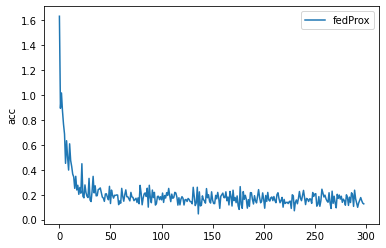

<Figure size 200x100 with 0 Axes>

In [ ]:
plt.plot(range(299),loss_total[0],label='fedProx')
#plt.plot(range(19),loss_total[1],label='fedAvg')
#plt.plot(range(19),loss_total[2],label='fedIR')
#plt.plot(range(19),loss_total[3],label='fedExt')
plt.ylabel('acc')
plt.legend()
plt.figure(figsize=(2, 1), dpi=100)
plt.savefig('acc')

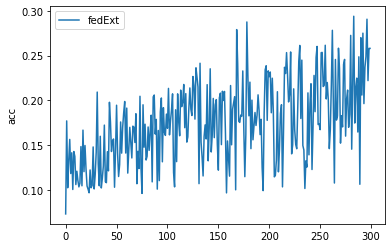

<Figure size 200x100 with 0 Axes>

In [ ]:
#plt.plot(range(20),acc[0],label='fedProx')
#plt.plot(range(20),acc[1],label='fedAvg')
#plt.plot(range(20),acc[2],label='fedIR')
plt.plot(range(300),acc[3],label='fedExt')
plt.ylabel('acc')
plt.legend()
plt.figure(figsize=(2, 1), dpi=100)
plt.savefig('acc')

#btch norm lenet

lerning rate

In [ ]:
learning_rates=[0.2,0.15,0.1,0.08,0.06,0.05,0.04,0.02,0.01,0.005]
weight_decay=10**-4
loss=nn.CrossEntropyLoss()
results=[]
acc_val=[]
z=0
for lr in learning_rates:
  net=LeNet_BatchNorm(3,10)
  net.to('cuda')

  optimizer=torch.optim.SGD(net.parameters(),lr,weight_decay)
  for i in range(30):
    lo,acc=train(net,loaders[0],optimizer,loss,'cuda')
    if(i==29):
      z=z+1
      results.append(f'lr= {lr}: loss= {lo}, acc= {acc}')
      print(f'step {z} out of {len(learning_rates)}')
  acc_val.append(test(net,loaders[1],'cuda'))

torch.save({'acc_val':acc_val,'training':results},'parameter-tuning-batch-lenet')

centralized

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


step 0 out of 120
step 1 out of 120
step 2 out of 120
step 3 out of 120
step 4 out of 120
step 5 out of 120
step 6 out of 120
step 7 out of 120
step 8 out of 120
step 9 out of 120
step 10 out of 120
step 11 out of 120
step 12 out of 120
step 13 out of 120
step 14 out of 120
step 15 out of 120
step 16 out of 120
step 17 out of 120
step 18 out of 120
step 19 out of 120
step 20 out of 120
step 21 out of 120
step 22 out of 120
step 23 out of 120
step 24 out of 120
step 25 out of 120
step 26 out of 120
step 27 out of 120
step 28 out of 120
step 29 out of 120
step 30 out of 120
step 31 out of 120
step 32 out of 120
step 33 out of 120
step 34 out of 120
step 35 out of 120
step 36 out of 120
step 37 out of 120
step 38 out of 120
step 39 out of 120
step 40 out of 120
step 41 out of 120
step 42 out of 120
step 43 out of 120
step 44 out of 120
step 45 out of 120
step 46 out of 120
step 47 out of 120
step 48 out of 120
step 49 out of 120
step 50 out of 120
step 51 out of 120
step 52 out of 120
ste

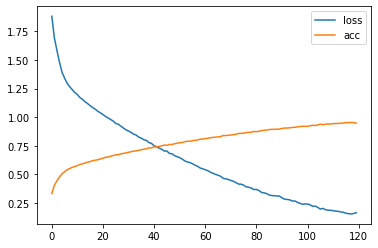

In [ ]:
lr=0.08

net=LeNet_BatchNorm(3,10)
net.to('cuda')
lo,acc=[],[]
optimizer=torch.optim.SGD(net.parameters(),lr,weight_decay)
for i in range(120):
  x,y=train(net,loaders[0],optimizer,loss,'cuda')
  print(f'step {i} out of 120')
  lo.append(x)
  acc.append(y)
accuracy=test(net,loaders[1],'cuda')
plt.plot(range(120),lo,label='loss')
plt.plot(range(120),acc,label='acc')
plt.legend()

In [ ]:
accuracy

0.5325

In [ ]:
acc=[[],[],[],[]]
loss_total=[]
alph=0.1
k=200

model_generation={
    'type':'gan',
    'model':generator,
    'Nz':100,
    #'mean':np.zeros(128),
    #'cov':cov_tiny_img_net,
}
'''
for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.08,model='lenet_batchnorm',clients_per_round=0.2,nbclients=20,mode='fedProx',mu=1,nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[0].append(x)
  if i==k-1:
    loss_total.append(z)

for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.08,model='lenet_batchnorm',clients_per_round=0.2,nbclients=20,mode='fedAvg',nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[1].append(x)
  if i==k-1:
    loss_total.append(z)
    
for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.08,model='lenet_batchnorm',clients_per_round=0.2,nbclients=20,mode='fedir',nb_rounds=i)
  x=test(model,loader[-1],'cuda')
  acc[2].append(x)
  if i==k-1:
    loss_total.append(z)
'''
for i in range(k):
  model,loader,z=federated_training(data,alpha=alph,lr=0.08,model='lenet_batchnorm',clients_per_round=0.2,nbclients=20,mode='fedExt',
                                    generation_model=model_generation,wr=1.5,fr=0.6,nb_rounds=i,cycle=False)
  model2=copy.deepcopy(model)
  model2.L2.weight.data=(model2.L2.weight[:10,:])
  model2.L2.bias.data=model2.L2.bias[:10]
  model2.L2.out_features=10
  x=test(model2,loader[-1],'cuda')
  acc[3].append(x)
  if i==k-1:
    loss_total.append(z)


In [ ]:
plt.plot(range(300),loss_total[0])